## Final Project Submission

Please fill out:
* Student name: Dirk Van Curan
* Student pace: Full time
* Scheduled project review date/time:  August 23, 2019 9:30 am
* Instructor name: Cristian
* Blog post URL:


In [ ]:
# Your code here - remember to use markdown cells for comments as well!

In [ ]:
"""This file contains some in progress code on our Mod 1 project.
In this project, we are given real estate sales data from King
County in Seattle, and we are asked to make a predictor for price."""

In [1]:
# import modules needed for data analysis and get them ready for use in the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [2]:
# import the given data and store it in a pandas DataFrame
raw_data = pd.read_csv("kc_house_data.csv")

## Initial exploration of what the data looks like

In [ ]:
raw_data.shape

In [ ]:
raw_data.head(20).T

In [ ]:
raw_data.info()

## Decided to use only the zipcodes of each sale as a initial model

In [3]:
# Convert the zipcodes to an array of One Hot values instead of a column of integers
# Zipcodes are not really useful as integers since they are actually categorical 
# values and being in a zipcode or not is more helpful for the model
ohe = OneHotEncoder(drop='first', categories='auto') 

In [4]:
price_zip_trans = ohe.fit_transform(raw_data['zipcode'].values.reshape(-1,1))

In [5]:
ohe.get_feature_names()

array(['x0_98002', 'x0_98003', 'x0_98004', 'x0_98005', 'x0_98006',
       'x0_98007', 'x0_98008', 'x0_98010', 'x0_98011', 'x0_98014',
       'x0_98019', 'x0_98022', 'x0_98023', 'x0_98024', 'x0_98027',
       'x0_98028', 'x0_98029', 'x0_98030', 'x0_98031', 'x0_98032',
       'x0_98033', 'x0_98034', 'x0_98038', 'x0_98039', 'x0_98040',
       'x0_98042', 'x0_98045', 'x0_98052', 'x0_98053', 'x0_98055',
       'x0_98056', 'x0_98058', 'x0_98059', 'x0_98065', 'x0_98070',
       'x0_98072', 'x0_98074', 'x0_98075', 'x0_98077', 'x0_98092',
       'x0_98102', 'x0_98103', 'x0_98105', 'x0_98106', 'x0_98107',
       'x0_98108', 'x0_98109', 'x0_98112', 'x0_98115', 'x0_98116',
       'x0_98117', 'x0_98118', 'x0_98119', 'x0_98122', 'x0_98125',
       'x0_98126', 'x0_98133', 'x0_98136', 'x0_98144', 'x0_98146',
       'x0_98148', 'x0_98155', 'x0_98166', 'x0_98168', 'x0_98177',
       'x0_98178', 'x0_98188', 'x0_98198', 'x0_98199'], dtype=object)

In [6]:
# this takes the One Hot encoded array and makes a new sparse DataFrame
# the column names are the zipcodes and the values are Boolean 1s or 0s
# depending on if the sale happened in that zipcode
zip_sparce = pd.DataFrame(price_zip_trans.todense(), columns=ohe.get_feature_names())

In [7]:
# adding the sale prices as a new column to the sparse array so that it can be
# used in a model
zip_sparce['price'] = raw_data['price']

In [8]:
# initial examination of correlation between price and zipcode
zip_sparce.corr()['price'].sort_values(ascending=False)

price       1.000000
x0_98004    0.271184
x0_98039    0.212561
x0_98040    0.204952
x0_98112    0.169957
x0_98006    0.133677
x0_98033    0.102551
x0_98105    0.091003
x0_98075    0.088634
x0_98199    0.083688
x0_98119    0.078077
x0_98102    0.068037
x0_98109    0.065875
x0_98005    0.065075
x0_98074    0.057136
x0_98053    0.051394
x0_98052    0.047205
x0_98177    0.040503
x0_98077    0.037336
x0_98115    0.036113
x0_98008    0.033039
x0_98122    0.029935
x0_98027    0.029138
x0_98116    0.026584
x0_98029    0.024190
x0_98103    0.020628
x0_98144    0.018815
x0_98007    0.016982
x0_98117    0.016123
x0_98107    0.011798
              ...   
x0_98166   -0.022561
x0_98028   -0.024406
x0_98125   -0.026613
x0_98045   -0.027633
x0_98019   -0.029616
x0_98148   -0.035762
x0_98126   -0.040609
x0_98056   -0.044989
x0_98155   -0.046074
x0_98108   -0.046840
x0_98118   -0.051608
x0_98188   -0.054438
x0_98146   -0.057217
x0_98032   -0.060024
x0_98022   -0.063552
x0_98133   -0.063775
x0_98178   -0

In [ ]:
price_array = np.asarray(zip_sparce['price'])

price_array

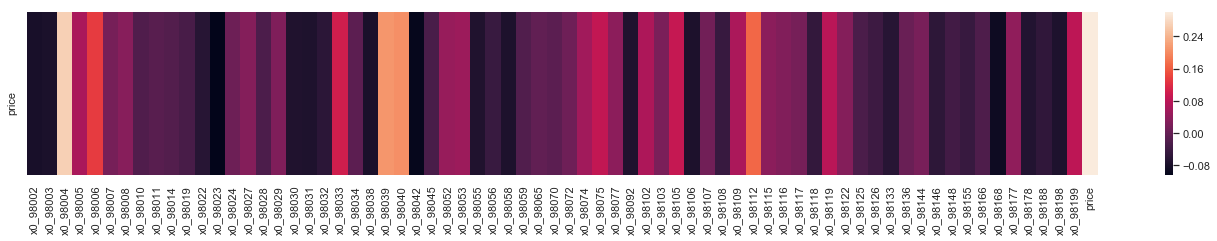

In [9]:
import seaborn as sns
sns.set(rc={'figure.figsize':(24,3)})
sns.heatmap(zip_sparce.corr().loc[['price']],vmax=0.3);

## Begin doing linear regression

In [ ]:
# Choose our predictors for the model
X = zip_sparce.drop('price', axis=1)
y = zip_sparce['price']
X.info()

In [ ]:
# Initial rough model for exploration
predictors = sm.add_constant(X)
model = sm.OLS(y, predictors).fit()
model.summary()

## Try with improved modeling (not StatsModels)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(zip_sparce.drop('price', axis=1), 
                                                    zip_sparce['price'],
                                                   random_state=42)

In [11]:
# Let's create a StandardScaler object to scale our data for us.
ss = StandardScaler()

# Now we'll apply it to our data by using the .fit() and transform() methods.
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)


In [12]:
# Now we can fit a LinearRegression object to our training data!

lr = LinearRegression()
lr.fit(X_train_sc, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
lr.score(X_test_sc, y_test)


0.387591458202281

In [14]:
# We can use the .coef_ attribute to recover the results
# of the regression.

lr.coef_

array([-4.82349229e+03,  1.15698571e+03,  1.21150874e+05,  4.60340682e+04,
        8.21855411e+04,  2.64102671e+04,  4.15911916e+04,  9.24496418e+03,
        1.95015371e+04,  1.33166767e+04,  1.30951930e+04,  2.39638452e+03,
       -1.35963760e+01,  2.01585401e+04,  4.56544890e+04,  1.94666322e+04,
        3.92879898e+04,  9.21839732e+02,  1.97443586e+03, -2.28443088e+03,
        7.06854182e+04,  3.77822871e+04,  1.22570994e+04,  9.46133986e+04,
        1.06955518e+05,  3.78342183e+03,  1.56209281e+04,  5.73225296e+04,
        5.25296800e+04,  2.14425934e+03,  1.76420091e+04,  8.94183110e+03,
        3.07107054e+04,  2.99727665e+04,  1.48846672e+04,  3.11342276e+04,
        5.54421314e+04,  6.71899854e+04,  3.97221582e+04,  5.58357306e+03,
        4.42408192e+04,  5.04810970e+04,  6.23634700e+04,  4.24423214e+03,
        3.10516574e+04,  6.85256710e+03,  4.18216413e+04,  9.48366762e+04,
        5.36896720e+04,  3.99097948e+04,  4.65757913e+04,  1.98803644e+04,
        5.46941423e+04,  

In [15]:
# And .intercept_

lr.intercept_

541284.4615669568

In [16]:
X_train.columns

Index(['x0_98002', 'x0_98003', 'x0_98004', 'x0_98005', 'x0_98006', 'x0_98007',
       'x0_98008', 'x0_98010', 'x0_98011', 'x0_98014', 'x0_98019', 'x0_98022',
       'x0_98023', 'x0_98024', 'x0_98027', 'x0_98028', 'x0_98029', 'x0_98030',
       'x0_98031', 'x0_98032', 'x0_98033', 'x0_98034', 'x0_98038', 'x0_98039',
       'x0_98040', 'x0_98042', 'x0_98045', 'x0_98052', 'x0_98053', 'x0_98055',
       'x0_98056', 'x0_98058', 'x0_98059', 'x0_98065', 'x0_98070', 'x0_98072',
       'x0_98074', 'x0_98075', 'x0_98077', 'x0_98092', 'x0_98102', 'x0_98103',
       'x0_98105', 'x0_98106', 'x0_98107', 'x0_98108', 'x0_98109', 'x0_98112',
       'x0_98115', 'x0_98116', 'x0_98117', 'x0_98118', 'x0_98119', 'x0_98122',
       'x0_98125', 'x0_98126', 'x0_98133', 'x0_98136', 'x0_98144', 'x0_98146',
       'x0_98148', 'x0_98155', 'x0_98166', 'x0_98168', 'x0_98177', 'x0_98178',
       'x0_98188', 'x0_98198', 'x0_98199'],
      dtype='object')